In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [3]:
%%R --o data_resp

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(nLooks=mean(nLooks)) %>%
      #mutate(within_x=mean(pInGaze**0.5)) %>%

      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.) %>%
      group_by(Subject, pid)%>%
      filter(length(Subject) > 0) 


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [4]:
data_resp = pandas2ri.ri2py(data_resp)

In [5]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject"])
dots_shown,dots_counted,pct_area,seen,n_look,pid,times=[],[],[],[],[],[],[]
for i,subj in subj_group:
    dots_shown.append(list(subj["Dots_Shown"]))
    dots_counted.append(list(subj["Dots_Counted"]))
    pct_area.append(list(subj["pctArea"] * 0.95))
    seen.append(list(subj["within_x_tot"]))
    n_look.append(list(subj["nLooks"]))
    pid.append(list(subj["Subject"]))
    times.append([float(i) for i in list(subj["Time"])])

ns = [len(n) for n in seen]
min_n = min(ns)



dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)
times = remove_n(times, min_n)
pid = remove_n(pid, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
n_look = np.array(n_look)
unseen = dots_shown - seen
times = np.array(times)
pid = np.array(pid)



with pm.Model() as mod:
    #group-level parameters
    
    #mean slope
    b_seen_grp = pm.HalfNormal("b_seen_grp", sd=10,testval=1)
    b_unseen_grp = pm.HalfNormal("b_unseen_grp",sd=10,testval=1)
    #b_nlook_grp = pm.HalfNormal("b_nlook_grp",sd=1,testval=0.5)
    
    sd_seen_grp = pm.HalfNormal("sd_seen_grp",sd=10,testval=5)
    sd_unseen_grp = pm.HalfNormal("sd_unseen_grp",sd=10,testval=5)
    sd_nlook_grp = pm.HalfNormal("sd_nlook_grp",sd=1, testval=0.1)
    
    #noise sd
    sd_noise_grp = pm.HalfNormal("b_noise_grp", sd=10,testval=5)

    #alpha hyperparams
    theta_seen_grp = pm.Beta("theta_seen_grp", 1,1)
    theta_unseen_grp = pm.Beta("theta_unseen_grp", 1,1)
    lambda_seen_grp = pm.Exponential("lambda_seen_grp",1)
    lambda_unseen_grp = pm.Exponential("lambda_unseen_grp",1)

    #subject-level parameters
    b_seen_subj = pm.Normal("b_seen_subj",mu=b_seen_grp,sd=sd_seen_grp, shape=(len(seen),1))
    b_unseen_subj = pm.Normal("b_unseen_subj",mu=b_unseen_grp,sd=sd_unseen_grp, shape=(len(unseen),1))
    b_nlook_subj = pm.HalfNormal("b_nlook_subj", sd=sd_nlook_grp, shape=(len(seen),1))

    alpha_seen_subj = pm.Beta("alpha_seen_subj",
                                 theta_seen_grp * lambda_seen_grp, 
                                  (1-theta_seen_grp) * lambda_seen_grp, shape=(len(seen),1))
    alpha_unseen_subj = pm.Beta("alpha_unseen_subj",
                                theta_unseen_grp * lambda_unseen_grp, 
                                  (1-theta_unseen_grp) * lambda_unseen_grp, shape=(len(unseen),1))

    b_noise_subj = pm.HalfNormal("b_noise_subj", sd=sd_noise_grp, shape=(len(unseen),1))
    #a_noise_subj = pm.HalfNormal("a_noise_subj", sd=10, shape=(len(unseen),1))

    guess_mean = ((1+b_nlook_subj*n_look)* b_seen_subj * seen * (1/pct_area) ** alpha_seen_subj + 
                  b_unseen_subj * unseen * (1./(1-pct_area)) ** alpha_unseen_subj)
    noise_mean =  b_noise_subj * guess_mean
    #noise_mean = (1. - pct_area) * b_noise_subj + a_noise_subj

    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=noise_mean, observed=dots_counted)
    trace = pm.sample(100, tune=50, cores=2, njobs=2, chains=2)



summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_noise_subj_log__, alpha_unseen_subj_logodds__, alpha_seen_subj_logodds__, b_nlook_subj_log__, b_unseen_subj, b_seen_subj, lambda_unseen_grp_log__, lambda_seen_grp_log__, theta_unseen_grp_logodds__, theta_seen_grp_logodds__, b_noise_grp_log__, sd_nlook_grp_log__, sd_unseen_grp_log__, sd_seen_grp_log__, b_unseen_grp_log__, b_seen_grp_log__]
100%|██████████| 150/150 [01:19<00:00,  1.89it/s]
Only 100 samples in chain.
The acceptance probability does not match the target. It is 0.9337794242023031, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergenc

                             mean        sd  mc_error       hpd_2.5  hpd_97.5  \
b_seen_subj__0_0         0.750277  0.052563  0.004001  6.392273e-01  0.842547   
b_seen_subj__1_0         0.779517  0.055843  0.003872  6.490536e-01  0.866858   
b_seen_subj__2_0         0.869158  0.084780  0.006667  7.068372e-01  1.024465   
b_seen_subj__3_0         0.815163  0.076728  0.005728  6.807659e-01  0.943621   
b_seen_subj__4_0         0.899432  0.077465  0.005904  7.448042e-01  1.052204   
b_seen_subj__5_0         0.884556  0.078287  0.006028  7.495898e-01  1.054288   
b_seen_subj__6_0         0.787540  0.067111  0.005047  6.801816e-01  0.934250   
b_seen_subj__7_0         0.833742  0.063897  0.004803  7.112091e-01  0.964780   
b_seen_subj__8_0         0.817698  0.074596  0.005401  6.861568e-01  0.963214   
b_seen_subj__9_0         0.769125  0.073729  0.005220  6.108780e-01  0.906329   
b_seen_subj__10_0        0.772586  0.056566  0.004415  6.634530e-01  0.894451   
b_seen_subj__11_0        0.6

In [6]:
summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

vals = {}
rownames = list(summary.index)

n_groups = seen.shape[0]
n_per_group = seen.shape[1]

print(summary_mean)
print(summary_sd)


vals = {}
for i in range(len(rownames)):
    rowname = rownames[i]
    #rowname = rowname[:rowname.find("__")]

    if 'grp' in rowname:
        rowname = rowname[:rowname.find("_grp")+4]
        vals[rowname] = [summary_mean[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group*n_groups)]

    else:
        rowname = rowname[:rowname.find("_subj")+5]

        if rowname not in vals:
            vals[rowname] = [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group)]
        else:
            vals[rowname] += [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] += [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] += [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] += [summary_high[i] for _ in range(n_per_group)]

   # print((i, (i%n_groups), rownames[i], summary_mean[i]))

vals["pid"] = np.ravel(pid)
vals["Subject"] = np.ravel(pid)

vals["Time"] = np.ravel(times)
vals["Dots_Shown"] = np.ravel(dots_shown)
vals["Dots_Counted"] = np.ravel(dots_counted)
vals["within_x_tot"] = np.ravel(seen)
vals["pctArea"] = np.ravel(pct_area)
vals["nLooks"] = np.ravel(n_look)


sum_vals=pd.DataFrame(vals)
pandas2ri.py2ri(sum_vals)

b_seen_subj__0_0           0.750277
b_seen_subj__1_0           0.779517
b_seen_subj__2_0           0.869158
b_seen_subj__3_0           0.815163
b_seen_subj__4_0           0.899432
b_seen_subj__5_0           0.884556
b_seen_subj__6_0           0.787540
b_seen_subj__7_0           0.833742
b_seen_subj__8_0           0.817698
b_seen_subj__9_0           0.769125
b_seen_subj__10_0          0.772586
b_seen_subj__11_0          0.659080
b_seen_subj__12_0          0.590044
b_seen_subj__13_0          0.938796
b_seen_subj__14_0          0.837119
b_seen_subj__15_0          0.734042
b_seen_subj__16_0          0.718361
b_seen_subj__17_0          0.790566
b_seen_subj__18_0          0.867270
b_seen_subj__19_0          0.831289
b_seen_subj__20_0          0.748487
b_seen_subj__21_0          0.970988
b_seen_subj__22_0          0.743335
b_seen_subj__23_0          0.827430
b_seen_subj__24_0          0.720973
b_seen_subj__25_0          0.759562
b_unseen_subj__0_0         0.612393
b_unseen_subj__1_0         0

Dots_Counted,Dots_Shown,Subject,...,theta_unseen_grp_low,theta_unseen_grp_sd,within_x_tot
20.000000,18.000000,'rup',...,0.036635,0.112968,9.376330
60.000000,89.000000,'rup',...,0.036635,0.112968,39.684492
30.000000,36.000000,'rup',...,0.036635,0.112968,17.754569
45.000000,86.000000,'rup',...,0.036635,0.112968,41.580757
...,...,...,...,...,...,...
35.000000,66.000000,'qto',...,0.036635,0.112968,36.864337
35.000000,76.000000,'qto',...,0.036635,0.112968,46.651030


[1] "list"
[1] 0.7962034
[1] 0.8636729
[1] 0.7328697
[1] 0.5291147
[1] 0.6402719
[1] 0.3993089
[1] ""
[1] 0.1289154
[1] 0.2213426
[1] 0.04931558
[1] 0.2247604
[1] 0.4677027
[1] 0.03663473
[1] ""
[1] 0.01435986
[1] 0.04877074
[1] 5.970221e-05


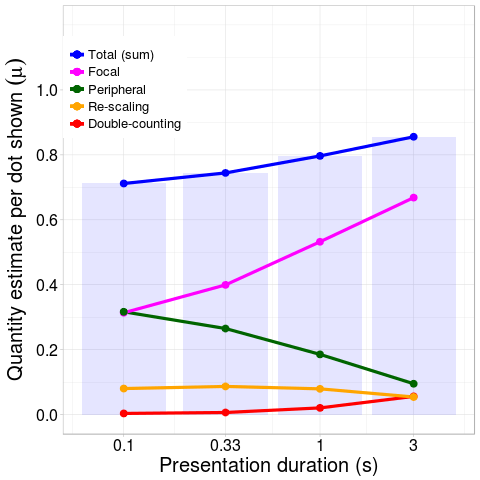

In [158]:
%%R -i sum_vals summary

print(typeof(sum_vals))
#get model estimates for each participant
sum_vals <- sum_vals %>%
             mutate(Time=as.factor(Time)) %>%
             mutate(time_num=as.numeric(as.character(Time))) %>%
             mutate(unseen = (Dots_Shown - within_x_tot)) %>%
             mutate(focal = b_seen_subj *within_x_tot) %>%
             mutate(focal_rescale=focal* (1/pctArea) ** alpha_seen_subj) %>%
             mutate(peripheral = b_unseen_subj * unseen) %>%
             mutate(peripheral_rescale =  (b_unseen_subj * unseen * (1./(1.-pctArea))**alpha_unseen_subj)) %>%
             mutate(focal_memory= focal_rescale* b_nlook_subj * nLooks*2) %>%
             mutate(model_guess = (1+b_nlook_subj*nLooks)*(b_seen_subj * within_x_tot * ((1/pctArea) ** alpha_seen_subj)) + 
                        b_unseen_subj * unseen * (1./(1.-pctArea))**alpha_unseen_subj) %>%
             mutate(model_noise = b_noise_subj * model_guess)  #%>%
           # group_by(pid, Subject, Time) %>%
            # mutate(mean_PL=mean(log(pathLength)))

sum_vals$id <- seq.int(1,nrow(sum_vals))
mean_reg_vals <- sum_vals %>%
                group_by(Subject, as.factor(Time))%>%
                top_n(n=1,wt=id)



p.1 <- ggplot(data=sum_vals) +
        geom_errorbar(aes(x=Dots_Shown, ymin=model_guess - model_noise,
                                 ymax=model_guess+model_noise, color="Model"), alpha=0.04,width=1,size=10) +
        #geom_line(aes(x=Dots_Shown, y=model_guess, color="Model")) +
        geom_point(aes(x=Dots_Shown, y=Dots_Counted,color="Human")) +
        scale_color_manual(values=c("black","blue")) +
         
        facet_wrap(~pid) +
        paper_theme_2 + theme(legend.title=element_blank(), 
                                  legend.text=element_text(size=14)) +
        ggtitle("Model predictions") +
        geom_abline(linetype="dashed")


p.1.1 <- ggplot(data=sum_vals) +


        stat_smooth(method="lm",fullrange=TRUE, aes(x=Dots_Shown,
                                    y=peripheral_rescale + focal_rescale + focal_memory,
                                    color="With double-counting", fill="With double-counting"),
                                    position="stack", alpha=0.9) +
        stat_smooth(method="lm",fullrange=TRUE,aes(x=Dots_Shown, 
                                    y=focal_rescale + peripheral_rescale,
                                    color="Re-scaled", fill="Re-scaled"), position="stack",alpha=0.9) +
        stat_smooth(method="lm",fullrange=TRUE,aes(x=Dots_Shown, y=focal+peripheral, color="Focal+Peripheral",
                                                           fill="Focal+Peripheral"),  
                                    position="stack", alpha=0.9) +
        stat_smooth(method="lm", fullrange=TRUE,aes(x=Dots_Shown, y=focal, color="Focal", fill="Focal"), 
                                    position="stack", alpha=0.9) +
        #stat_summary_bin(bins=10, fun.y="mean", geom="point", aes(x=Dots_Shown, y=Dots_Counted)) +
        
        xlim(0,80) +
        #ylim(1,80) +
        #guides(fill=FALSE) +
        scale_color_manual(name="Model", values=c("red", "blue", "darkgreen", "orange"), 
                         labels=c("Focal", "Focal+Peripheral", "Re-scaled", "With double-counting")) +
        scale_fill_manual(name="Model",values=c("red", "blue", "darkgreen", "orange"), 
                        labels=c("Focal", "Focal+Peripheral", "Re-scaled", "With double-counting")) +
        guides(color=guide_legend(reverse = TRUE), fill=guide_legend(reverse = TRUE)) +
        xlab("Number shown") + ylab("Model estimate") +
        #scale_color_manual(values=c("black","blue")) +
         paper_theme_2 + theme(legend.title=element_blank(), 
                                   legend.text=element_text(size=10),
                               axis.title.x=element_text(face="plain", size=12), 
                              axis.title.y=element_text(face="plain", size=12))  


p.1.2 <- ggplot(data=sum_vals) +
        stat_summary(aes(x=Time, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown, 
                         color="With double-counting", fill="With double-counting"),geom="bar",
                             width=1) +
        stat_summary(aes(x=Time, y=(focal_rescale+peripheral_rescale)/Dots_Shown, 
                         color="Re-scaled", fill="Re-scaled"),geom="bar",width=1) +
        stat_summary(aes(x=Time, y=(focal+peripheral)/Dots_Shown, color="FPeripheral",
                         fill="Peripheral"), geom="bar",width=1) +

        stat_summary(aes(x=Time, y=focal/Dots_Shown, color="Focal", fill="Focal"),geom="bar",
                      width=1) +
       # stat_summary(aes(x=Time, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown),geom="point",
                     #        width=1, color="black", size=2) +
        ylim(0,1.0) +
        #guides(fill=FALSE) +
        scale_color_manual(name="Model", values=c("red", "blue", "black","darkgreen", "orange"), 
                         labels=c("Focal", "Peripheral", "Re-scaled", "With double-counting", "Human")) +
        scale_fill_manual(name="Model",values=c("red", "blue","black", "darkgreen", "orange"), 
                        labels=c("Focal", "Peripheral", "Re-scaled", "With double-counting", "Human")) +
        guides(color=guide_legend(reverse = TRUE), fill=guide_legend(reverse = TRUE)) +
        xlab("Time") + ylab("Estimate per dot shown") +
        #scale_color_manual(values=c("black","blue")) +
         paper_theme_2 + theme(legend.title=element_blank(), legend.position=c(0.15,0.85),
                                   legend.text=element_text(size=12),
                               axis.title.x=element_text(face="plain", size=20, color="black"), 
                              axis.title.y=element_text(face="plain", size=20, color="black"),
                               axis.text.x=element_text(size=16), axis.text.y=element_text(size=16))  


p.1.3 <- ggplot(data=sum_vals) +
        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown),
                     geom="bar",alpha=0.1, fill="blue") +
        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown, 
                         color="Human"),geom="line", size=1.5) +
        stat_summary(aes(x=time_num, y=(focal_memory)/Dots_Shown, size=1.5,
                         color="Double-counting"),geom="line",size=1.5,
                             width=1) +
        stat_summary(aes(x=time_num, y=(focal_rescale + peripheral_rescale - (focal+peripheral))/Dots_Shown, 
                         color="Re-scaling"),geom="line",width=1, size=1.5) +
        stat_summary(aes(x=time_num, y=(peripheral)/Dots_Shown, color="Peripheral"
                        ), geom="line",width=1,size=1.5) +
        stat_summary(aes(x=time_num, y=focal/Dots_Shown, color="Focal"),geom="line",size=1.5,
                      width=1) +

        stat_summary(aes(x=time_num, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown, 
                         color="Human"),geom="point", size=3) +
        stat_summary(aes(x=time_num, y=focal/Dots_Shown, color="Focal"),geom="point",size=3) +
        stat_summary(aes(x=time_num, y=(focal_memory)/Dots_Shown, size=3,
                         color="Double-counting"),geom="point",size=3,
                             width=1) +
        stat_summary(aes(x=time_num, y=(focal_rescale + peripheral_rescale - (focal+peripheral))/Dots_Shown, 
                         color="Re-scaling"),geom="point",width=1, size=3) +
        stat_summary(aes(x=time_num, y=(peripheral)/Dots_Shown, color="Peripheral"
                        ), geom="point",width=1,size=3) +


       # stat_summary(aes(x=Time, y=(focal_rescale+peripheral_rescale+focal_memory)/Dots_Shown),geom="point",
                     #        width=1, color="black", size=2) +
        #ylim(0,1) +
        #guides(fill=FALSE) +
        scale_color_manual(name="Model", values=c("red","magenta", "blue",  "darkgreen", "orange"), 
                         labels=c("Total (sum)", "Focal", "Peripheral", "Re-scaling", "Double-counting"),
                          breaks=c("Human", "Focal", "Peripheral", "Re-scaling", "Double-counting")) +
       # scale_fill_manual(name="Model",values=c("red", "black", "blue", "darkgreen", "orange"), 
                   #    labels=c("Focal", "Peripheral", "Re-scaled", "With double-counting", 
                            #     expression(paste("Estimate/N ", (mu)))),
                     #   breaks=c("Focal", "Peripheral", "Re-scaled", "With double-counting", "Human")) +
        #scale_fill_manual(name="Human",values=c("black"), 
                #        labels="Total",
                        #labels=c(expression(paste("Estimate ", (mu)))),
                    #    breaks=c( "Human")) +
        scale_y_continuous(limits=c(0,1.2), breaks=seq.int(0,1,0.2)) +
        guides(color=guide_legend(reverse = FALSE), fill=FALSE) +
                       #fill=guide_legend(reverse = FALSE)) +
        xlab("Presentation duration (s)") + ylab(expression(paste("Quantity estimate per dot shown ", (mu)))) +
        #scale_color_manual(values=c("black","blue")) +
         paper_theme_2 + theme(legend.title=element_blank(), legend.position=c(0.15,0.81),
                                   legend.text=element_text(size=13),
                               axis.title.x=element_text(face="plain", size=20, color="black"), 
                              axis.title.y=element_text(face="plain", size=20, color="black"),
                               axis.text.x=element_text(size=16), axis.text.y=element_text(size=16)) +
       scale_x_log10(breaks=c(0.1,0.33,1,3), labels=c("0.1","0.33","1","3"))





#fs <- expression(paste(Foveal slope, paste("(", paste(beta[foveal], ")" ))))
fs <- expression(paste("Foveal slope ", paste("(", paste(beta[foveal], ")" ))))
ps <- expression(paste("Peripheral slope ", paste("(", paste(beta[peripheral], ")" ))))

p.2 <- ggplot(data=mean_reg_vals) +
        geom_point(aes(x=b_seen_subj, y=b_unseen_subj), size=3, alpha=0.8) +
        geom_point(aes(x=b_seen_grp, y=b_unseen_grp), color="blue", size=8, shape=3, alpha=0.8) +
        geom_point(aes(x=b_seen_grp, y=b_unseen_grp),color="blue", size=8, shape=20, alpha=0.8) +
        theme_light() + 
        paper_theme_3 +
        geom_abline() +
        xlim(0,1.5) + ylim(0,1.5) +
        xlab(fs) + 

        ylab(ps)# +
       # ggtitle("Focal v. peripheral contribution to mean (unscaled)")

fs <- expression(paste("Foveal re-scaling ", paste("(", paste(alpha, ")" ))))
ps <- expression(paste("Peripheral re-scaling ", paste("(", paste(gamma, ")" ))))

p.3 <- ggplot(data=mean_reg_vals) +
       #annotate("rect", xmin = 0.5, xmax = Inf,
            #    ymin = 0.5, ymax = Inf, fill= "red",
               #     alpha=0.1)+
       #annotate("rect", xmin = -Inf, xmax = 0.5, ymin = -Inf, ymax = 0.5 , fill= "blue", alpha=0.1) + 
       #annotate("rect", xmin = 1.05, xmax = 1.1, ymin = 0.8, ymax = 0.85, fill= "red", alpha=0.1)+
       #annotate("rect", xmin = 1.05, xmax = 1.1, ymin = 0.8, ymax = 0.85, fill= "blue", alpha=0.1)+

        geom_point(aes(x=0.25, y=.25, color="Accumulator", fill="Accumulator"),
                                   size=80, shape=22, alpha=0.03) +
        geom_point(aes(x=0.75, y=.75, color="Density", fill="Density"),
                                   size=80, shape=22, alpha=0.03) +
        geom_point(aes(x=0.5, y=.5, color="Accumulator", fill="Accumulator"),
                                   size=.1, shape=22, alpha=1) +
        geom_point(aes(x=0.5, y=.5, color="Density", fill="Density"),
                                   size=.1, shape=22, alpha=1) +
        geom_point(aes(x=alpha_seen_subj, y=alpha_unseen_subj), size=3, alpha=0.8) +
        geom_point(aes(x=theta_seen_grp, y=theta_unseen_grp), size=8, shape=20, color="blue", alpha=0.8) +
        geom_point(aes(x=theta_seen_grp, y=theta_unseen_grp), size=8, shape=3, color="blue", alpha=0.8) +

        theme_light() + 
        paper_theme_3 +
        theme(legend.title=element_blank(),
              legend.text=element_text(size=16),
              #legend.key.width = unit(2, "cm"),
              #  legend.key.height = unit(2, "cm"),
              #legend.key=element_rect(size=0.01), 
              legend.position=c(0.21,0.85)) +

        #geom_abline() +
        geom_hline(aes(yintercept=0.5), size=1.25) +
        geom_vline(aes(xintercept=0.5), size=1.25) +
        xlim(0,1) +
        ylim(0,1) + 
        # geom_segment(
      
        scale_x_continuous(expand = c(0, 0), limits=c(0,1),
                                   breaks=seq.int(0.2,0.8,0.2)) +
        scale_y_continuous(expand = c(0, 0), limits=c(0,1),
                                   breaks=seq.int(0,0.8,0.2)) +
        scale_color_discrete(guide=FALSE)+
        guides(fill = guide_legend(override.aes = list(size=5))) +
        #scale_fill_discrete(guide=FALSE)+
        xlab(fs) + 
        ylab(ps)# +


#print(p.1.1)
#ggsave("figs/CDF_models.png", dpi=300, width=6, height=4)
#print(p.1.2)
#ggsave("figs/Time_models.png", dpi=300, width=5, height=5)
#ggsave("figs/Time_models.pdf", dpi=300, width=9, height=5)
print(p.1.3)
ggsave("figs/Time_models_lines.pdf", dpi=300, width=7, height=5)

#print(p.1)
#print(p.2)
#ggsave("figs/focal_v_peripheral_estimate.png", width=5,height=5,dpi=400)
#print(p.3)
#ggsave("figs/rescaling.png", width=5,height=5,dpi=400)

print(mean(mean_reg_vals$b_seen_grp))
print(mean(mean_reg_vals$b_seen_grp_high))
print(mean(mean_reg_vals$b_seen_grp_low))

print(mean(mean_reg_vals$b_unseen_grp))
print(mean(mean_reg_vals$b_unseen_grp_high))
print(mean(mean_reg_vals$b_unseen_grp_low))
print("")
print(mean(sum_vals$theta_seen_grp))
print(mean(sum_vals$theta_seen_grp_high))
print(mean(sum_vals$theta_seen_grp_low))

print(mean(sum_vals$theta_unseen_grp))
print(mean(sum_vals$theta_unseen_grp_high))
print(mean(sum_vals$theta_unseen_grp_low))
print("")

print(mean(sum_vals$b_nlook_subj))
print(mean(sum_vals$b_nlook_subj_high))
print(mean(sum_vals$b_nlook_subj_low))

